<b> EDA Draft </b> 

<b>2. Preliminary exploratory data analysis:</b>


In [4]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(GGally)
install.packages("corrplot")
library(corrplot)
library(RColorBrewer)   
library(class)          
library(e1071)          
library(stringr)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [5]:
options(repr.matrix.max.rows = 10)

pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", "skew_integrated_profile",
                  "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", "skew_dmsnr", "class"))
pulsar_data <- pulsar_data |> drop_na()
head(pulsar_data)


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<b>Summarize the data in at least one table </b>

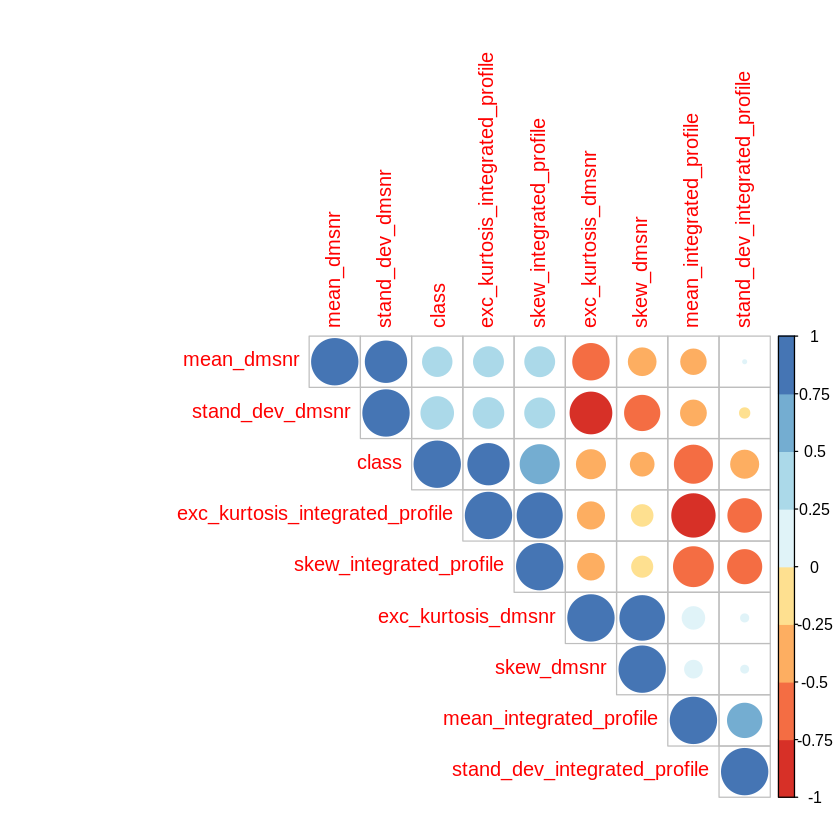

In [6]:
#Dataset Exploration Graph 1 (correlation)
cor_pulse <- cor(pulsar_data)
corrplot(cor_pulse, type="upper", order="hclust",col=brewer.pal(n=8, name="RdYlBu"))

We can see that there is a different correlation value between the variables where some of them are high value 

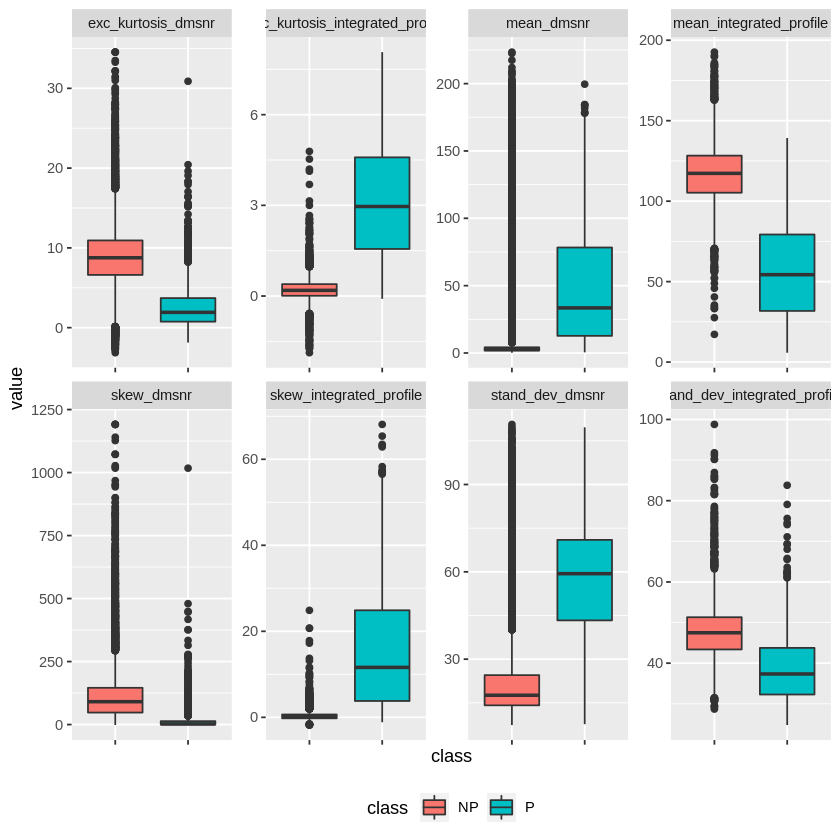

In [7]:
#Dataset Exploration Graph 2 (variable distribution)
pulsar_data$class <- ifelse(pulsar_data$class == 1, "P", "NP")

pulsar_data |> gather(predictors, value, -class) %>%
  ggplot(aes(class, value, fill = class)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free", ncol = 4) +
  theme(axis.text.x = element_blank(), legend.position="bottom")



The distribution graph above shows that some of the variable's value shows an evident differnce between pulsar and fake pulsar 

<b>Data Preparation</b>


In [8]:
pulsar_data_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_data_train <- training(pulsar_data_split)
pulsar_data_test <- testing(pulsar_data_split) 

In [ ]:
prop.table(table(pulsar_data_train$class))


        NP          P 
0.90888773 0.09111227 

In [ ]:
table(pulsar_data_train$class)


   NP     P 
12200  1223 

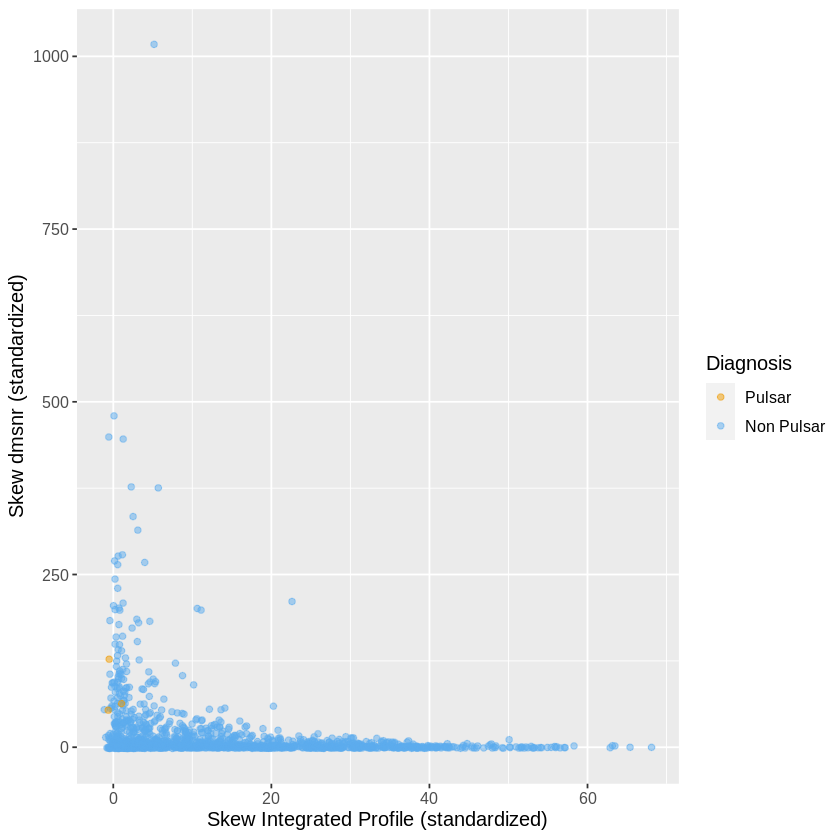

In [20]:
rare_pulsar <- bind_rows(
      filter(pulsar_data_train, class == "P"),
      pulsar_data_train |> filter(class == "NP") |> slice_head(n = 3)
    ) |>
    select(class, skew_integrated_profile, skew_dmsnr)

rare_plot <- rare_pulsar |>
  ggplot(aes(x = skew_integrated_profile, y = skew_dmsnr, color = class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Skew Integrated Profile (standardized)", 
       y = "Skew dmsnr (standardized)",
       color = "Diagnosis") +
  scale_color_manual(labels = c("Pulsar", "Non Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

rare_plot

As we can see from the proportion and plot, we have to balance the train data set. Otherwise we will not learn correctly. Indeed, the algorithm will not have enough information about Pulsar Star.

For the present purposes, it will suffice to rebalance the data by oversampling the rare class. In other words, we will duplicate randomly observations of class 1 until we have the same number of class 0 and class 1